In [1]:
import numpy as np
import rebound as rb
import reboundx as rbx
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [2]:
from celmech.nbody_simulation_utilities import get_canonical_heliocentric_orbits
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
from celmech import PlanarResonanceEquations

# Planar Resonance Equations

`celmech` has two classes, `PlanarResonanceEquations` and `SpatialResonanceEquatoins`, for modeling the averaved equtions of motion describing the dynamics of a mean motion resonance between two massive, planetary bodies orbiting a central star. 
This notebook demonstrates the `PlanarResonanceEquations`class.

The `PlanarResonanceEquations` evolve the dynamical variables 
$$\pmb{z}=(y_1,y_2,x_1,x_2)$$ and 
$${\cal D} \approx \Gamma_1 + \Gamma_2 - \frac{\beta_1\beta_2\Delta}{2\beta_1\sqrt{\alpha}(s+1)+\beta_2s}$$
where $(x_i,y_i) = \sqrt{2\Gamma_i} \times (\cos\sigma_i,\sin\sigma_i)$ with  $\sigma_i=(1+s)\lambda_2-s\lambda_1-\varpi_i$.

`PlanarResonanceEquations` can be used to evolve the full equations of motion
$$
 \frac{d}{dt}\pmb{z} = \Omega\cdot \nabla H(\pmb{z};{\cal D}) + \pmb{f}_{\pmb{z},\text{dis}}(\pmb{z};{\cal D})\\
 \frac{d}{dt}{\cal D} = {f}_{{\cal D},\text{dis}}(\pmb{z};{\cal D})
$$
which include dissipative terms $\pmb{f}_{\pmb{z},\text{dis}}$ and ${f}_{{\cal D},\text{dis}}$ that describe the evolution of the dynamical variables under the influence of eccentricity and semi-major axis damping or it can be used to evolve strictly conservative system without $\pmb{f}_{\pmb{z},\text{dis}}$ and ${f}_{{\cal D},\text{dis}}$, in which case $\cal D$ is a conserved quantity.

Additional details can be found [here](https://www.overleaf.com/read/shctxrxcvdpt). This notebook demonstrates how the 'ResonanceEquations' can be used to integrate the equations of motion and compare them with $N$-body integrations.

## set-up

Here we will get an object to model the equations of motion for a 3:2 mean motion resonance. 

Later, if we like, we can change the specific $j\mathrm{:}j-k$ mean motion resonance we're modelling by setting the `PlanarResonanceEquations.j` and `PlanarResonanceEquations.k` attributes.

The initialization of a `PlanarResonanceEquations` object can take a while as it requires the eqauations of motion to be generated and compiled by `theano`.

In [3]:
res_eqs = PlanarResonanceEquations(3,1)

#### Define some convenient functions for initializing and processing `rebound` simulations
We'll use rebound simulations as a convenient means of specifying intial conditions.

In [4]:
def get_sim(res_eqs,Delta,z1,z2,theta1,theta2):
    mstar = 1
    a1 = 1
    a2 = (1+Delta)**(+2/3)  / res_eqs.alpha
    e1,e2 = np.abs([z1,z2])
    pomega1,pomega2 = np.angle([z1,z2])
    lmbda2 = 0
    lmbda1 = (res_eqs.j * lmbda2 - res_eqs.k * pomega1 - theta1) / (res_eqs.j-res_eqs.k)
    sim = rb.Simulation()
    sim.add(m=mstar)
    sim.add(m=res_eqs.m1,a=a1,e=e1,l=lmbda1,pomega=pomega1)
    sim.add(m=res_eqs.m2,a=a2,e=e2,l=lmbda2,pomega=pomega2)
    sim.move_to_com()
    return sim

def get_results_from_sim(res_eqs,sim,times,sa_filename="sa.bin",extras_filename=None):
    sim.automateSimulationArchive(sa_filename,interval=times[1]-times[0],deletefile=True)
    sim.integrate(times[-1])
    if extras_filename:
        sa = rbx.SimulationArchive(sa_filename,extras_filename)
    else:
        sa = rb.SimulationArchive(sa_filename)
    nb_result = get_simarchive_integration_results(sa,coordinates='heliocentric')    
    nb_result['theta'] = np.array([res_eqs.k - res_eqs.j,res_eqs.j]) @ nb_result['l'] - nb_result['pomega']
    nb_result['theta'] = np.mod(nb_result['theta'],2*np.pi)
    nb_results_by_planet = {}
    for key,val in nb_result.items():
        if val.ndim>1:
            for i,quantity in enumerate(val):
                nb_results_by_planet["{:s}{:d}".format(key,i+1)] = quantity
        else:
            nb_results_by_planet[key] = val
    Pratio0=  res_eqs.j/(res_eqs.j-res_eqs.k)
    Pratio = nb_results_by_planet['P2']/nb_results_by_planet['P1']
    nb_results_by_planet['Delta'] = Pratio/Pratio0 - 1
    return nb_results_by_planet

#### Generate a set of dynamical variables (`dyvars`) as initial conditions
The `PlanarResonanceEquations.dyvars_from_rebound_simulation` method gives us initial conditions generated from a `rebound` simulation.

In [5]:
sim = get_sim(res_eqs,0.0025,0.06,-0.08,np.pi/2,3*np.pi/2)

In [6]:
dyvars = res_eqs.dyvars_from_rebound_simulation(sim,iIn=1,iOut=2)

#############################################################################
sim = res_eqs.dyvars_to_rebound_simulation(dyvars,osculating_correction=False)
# A new simulation is generated from the dynamical variables.
# The newly-generated simulation can differ from the original rebound
# simulation in the scale of the planets' semi-major axes.
# This is because the PlanarResonanceEquations normalizes its units
# based on the total angular momentum of the system.
#
# By generating a new simulation using the PlanarResonanceEquations
# method dyvars_to_rebound_simulation, the new simulation should match
# the default semimajor axis scale of the PlanarResonanceEquations
# object



# Integration

Integrate the resonace equations of motion.

In [7]:
times = np.linspace(0,1e4,512)
soln = res_eqs.integrate_initial_conditions(dyvars,times)
els_res_eqs = soln['orbital_elements']
# Take angles mod 2pi
els_res_eqs['theta1'] = np.mod(els_res_eqs['theta1'],2*np.pi)
els_res_eqs['theta2'] = np.mod(els_res_eqs['theta2'],2*np.pi)

Integrate corresponding full $N$-body equations

In [8]:
nb_results_by_planet = get_results_from_sim(res_eqs,sim,times)

# Process and plot results

Plot results

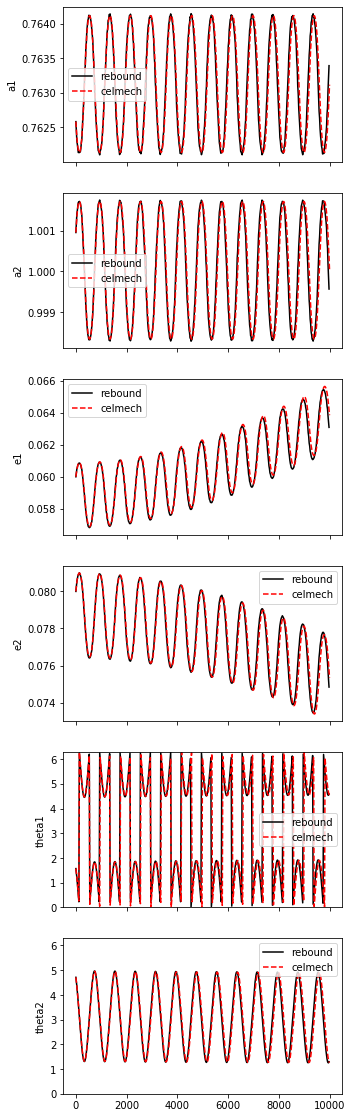

In [9]:
fig,axes = plt.subplots(len(els_res_eqs)-1,1,sharex=True,figsize=(5,20))
time1 = els_res_eqs['times']
time2 = nb_results_by_planet['time']
for i,key in enumerate(els_res_eqs.keys()):
    
    if key=='times':
        continue
    ax = axes[i]
    ax.plot(time2,nb_results_by_planet[key],'k-',label='rebound')
    ax.plot(time1,els_res_eqs[key],'r--',label='celmech')
    ax.legend()
    ax.set_ylabel(key)
    if key[0] is 't':
        ax.set_ylim(0,2*np.pi)

# Dissipative evolution

`PlanarResonaceEquations` can be used to evolve the system under the effect of dissipative forces
\begin{align}
    \frac{d\ln a_i}{dt} &= -\frac{1}{\tau_{m,i}} - 2p\frac{e_i^2}{\tau_{e,i}}\\
     \frac{d\ln e_i}{dt} &= -\frac{1}{\tau_{e,i}}
\end{align}

The dissipative forces are determined by setting the parameters `PlanarResonaceEquations.tau_alpha`, defined by
$$
\tau_\alpha^{-1} = \tau_{m,2}^{-1} - \tau_{m,1}^{-1}
$$
along with `PlanarResonaceEquations.K1` and `PlanarResonaceEquationsK2`, so that 
$$
\tau_{e,i} = \tau_\alpha/K_i
$$
and finally`PlanarResonaceEquations.p` which sets the coupling between eccentricity and semi-major axis damping. A value of `p=1` implies the eccentricity damping mechanism (approximately) preserves angular momentum.

#### set dissipation parameters

In [10]:
res_eqs.K1 = 20
res_eqs.K2 = 20
res_eqs.tau_alpha = 3e5
res_eqs.p = 0

#### integrate intial conditions with `celmech`

In [11]:
Delta0 = 0.007
e1_0 = 0.01
e2_0 = 0.01
theta1_0,theta2_0 = np.random.uniform(0,2*np.pi,2)
sim = get_sim(res_eqs,Delta0,e1_0,e2_0,theta1_0,theta2_0)
dyvars = res_eqs.dyvars_from_rebound_simulation(sim)
times = np.linspace(0,1e5,512)
soln = res_eqs.integrate_initial_conditions(dyvars,times,dissipation=True)
els_res_eqs = soln['orbital_elements']

# Store Delta
Pratio = (els_res_eqs['a2']/els_res_eqs['a1'])**(1.5)
Pratio0 = res_eqs.j / (res_eqs.j-res_eqs.k) 
els_res_eqs['Delta'] = Pratio/Pratio0  - 1

#### integrate initial conditions with `rebound` and `reboundx`

In [12]:
sim,rebx = res_eqs.dyvars_to_rebound_simulation(dyvars,include_dissipation=True,osculating_correction=False)
rebx.save("rebxarchive.bin")
nb_results_by_planet = get_results_from_sim(
    res_eqs,
    sim,
    times,
    sa_filename='sa_dis.bin',
    extras_filename='rebxarchive.bin'
)

/Users/shadden/Projects/00_Codes_And_Data/rebound/rebound/simulation.py:675: RuntimeWarning: REBOUNDx: Operators that affect particle trajectories with adaptive timesteps can give spurious results. Use sim.ri_ias15.epsilon=0 for fixed timestep with IAS, or use a different integrator.
  warnings.warn(msg[1:], RuntimeWarning)
/Users/shadden/Projects/00_Codes_And_Data/rebound/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


#### Process N-body results

Text(0.5, 0, 'Time')

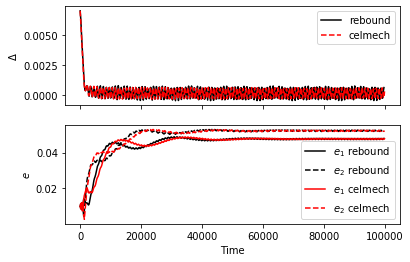

In [14]:
fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(nb_results_by_planet['time'],nb_results_by_planet['Delta'],'k',label='rebound')
ax[0].plot(soln['times'],els_res_eqs['Delta'],'r--',label='celmech')
ax[0].legend()
ax[0].set_ylabel(r"$\Delta$")
ax[1].plot(nb_results_by_planet['time'],nb_results_by_planet['e1'],'k-',label=r'$e_1$ rebound')
ax[1].plot(nb_results_by_planet['time'],nb_results_by_planet['e2'],'k--',label=r'$e_2$ rebound')
ax[1].plot(soln['times'],els_res_eqs['e1'],'r-',label=r'$e_1$ celmech')
ax[1].plot(soln['times'],els_res_eqs['e2'],'r--',label=r'$e_2$ celmech')
ax[1].legend()
ax[1].set_ylabel(r"$e$")
ax[1].set_xlabel(r"Time")

# Fixed point determination

The `PlanarResonanceEquations` class has a method, `find_equilibrium`, for determining the fixed point of the equations of motion using Newton's method. Here we compare the equilibrium configuration predicted with 
`PlanarResonanceEquations.find_equilibrium` to the configuration reached by the `rebound` $N$-body simulation we just ran.

#### determine equilibrium
Here we'll provide an initial guess to `PlanarResonanceEquations.find_equilibrium` by providing the configuration from one our early simulation snapshots.

In [15]:
sa = rbx.SimulationArchive("sa_dis.bin","rebxarchive.bin")
sim,_= sa[10]
guess = res_eqs.dyvars_from_rebound_simulation(sim)
z_eq = res_eqs.find_equilibrium(guess,dissipation=True,max_iter=30)
els_eq = res_eqs.dyvars_to_orbital_elements(z_eq)

/Users/shadden/Projects/00_Codes_And_Data/rebound/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


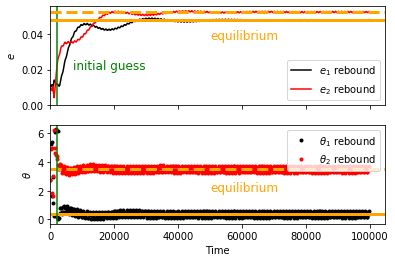

In [16]:
fig,ax = plt.subplots(2,sharex=True)
ax[0].plot(nb_results_by_planet['time'],nb_results_by_planet['e1'],'k-',label=r'$e_1$ rebound')
ax[0].plot(nb_results_by_planet['time'],nb_results_by_planet['e2'],'r-',label=r'$e_2$ rebound')

ax[0].legend()
ax[0].set_ylabel(r"$e$")

ax[0].axvline(sim.t,color='green')
ax[0].text(sim.t + 5000,0.02,"initial guess",fontsize=12,color='green')
ax[0].axhline(els_eq['e1'],ls='-',color='orange',lw=3)
ax[0].axhline(els_eq['e2'],ls='--',color='orange',lw=3)
ax[0].text(5e4,0.037,"equilibrium",fontsize=12,color='orange')
ax[0].set_ylim(ymin=0)
ax[0].set_xlim(xmin=0)

ax[1].plot(nb_results_by_planet['time'],nb_results_by_planet['theta1'],'k.',label=r'$\theta_1$ rebound')
ax[1].plot(nb_results_by_planet['time'],nb_results_by_planet['theta2'],'r.',label=r'$\theta_2$ rebound')
ax[1].axhline(els_eq['theta1'],ls='-',color='orange',lw=3)
ax[1].axhline(np.mod(els_eq['theta2'],2*np.pi),ls='--',color='orange',lw=3)
ax[1].axvline(sim.t,color='green')
ax[1].set_xlabel(r"Time")
ax[1].set_ylabel(r"$\theta$")
ax[1].text(5e4,2,"equilibrium",fontsize=12,color='orange')
ax[1].legend()